# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

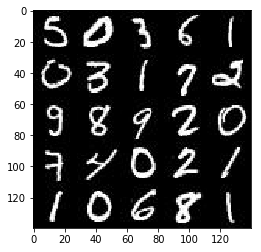

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

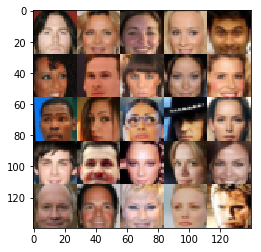

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [91]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels))
    input_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim))
    lr = tf.placeholder(dtype=tf.float32)

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [278]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xchannels
        conv = tf.layers.conv2d(inputs=images, filters=32, kernel_size=5, strides=2, padding='SAME', activation=None)
        # Output of Conv layer 1, 14x14x32
        
        conv = tf.layers.conv2d(inputs=conv, filters=64, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv = tf.nn.leaky_relu(tf.layers.batch_normalization(conv), alpha)
        # Output of Conv layer 2, 7x7x64
        
        conv = tf.layers.conv2d(inputs=conv, filters=128, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv = tf.nn.leaky_relu(tf.layers.batch_normalization(conv), alpha)
        # Output of Conv layer 3, 4x4x128
        
        logits = tf.reshape(conv,(-1, 4*4*128))
        logits = tf.contrib.layers.fully_connected(logits, 1, activation_fn=None)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [279]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator',reuse=not is_train):
        x = tf.contrib.layers.fully_connected(z, 7*7*256, activation_fn=None)
        x = tf.reshape(x, (-1,7,7,256))
        x = tf.nn.leaky_relu(tf.layers.batch_normalization(x, training=is_train), alpha)
        # First fully connected layer, 7x7x256

        conv = tf.layers.conv2d_transpose(inputs=x, filters=128, kernel_size=5, strides=2, padding='same', activation=None)
        conv = tf.nn.leaky_relu(tf.layers.batch_normalization(conv, training=is_train), alpha)
        # Output of Conv layer 1, 14x14x128
        
        conv = tf.layers.conv2d_transpose(inputs=conv, filters=64, kernel_size=5, strides=1, padding='same', activation=None)
        conv = tf.nn.leaky_relu(tf.layers.batch_normalization(conv, training=is_train), alpha)
        # Output of Conv layer 1, 28x28x64
        
        logits = tf.layers.conv2d_transpose(inputs=conv, filters=out_channel_dim, kernel_size=5, strides=2, padding='same', activation=None)
        # Output layer, 28x28xchannels
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [298]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # As per https://github.com/soumith/ganhacks#6-use-soft-and-noisy-labels
    real_labels = tf.random_uniform(shape=tf.shape(d_model_real), minval=0.7, maxval=1.2)
    fake_labels = tf.random_uniform(shape=tf.shape(d_model_fake), minval=0, maxval=0.3)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=real_labels))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=fake_labels))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [299]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [300]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [304]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model   
        
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                # Use gaussian as per https://github.com/soumith/ganhacks#3-use-a-spherical-z
                batch_z = np.random.normal(0.0, 1.0, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4788... Generator Loss: 0.3629
Epoch 1/2... Discriminator Loss: 1.3663... Generator Loss: 0.5675
Epoch 1/2... Discriminator Loss: 1.3068... Generator Loss: 0.6814
Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 0.6085
Epoch 1/2... Discriminator Loss: 1.4412... Generator Loss: 0.6400
Epoch 1/2... Discriminator Loss: 1.4073... Generator Loss: 0.6906
Epoch 1/2... Discriminator Loss: 1.4031... Generator Loss: 0.6683
Epoch 1/2... Discriminator Loss: 1.3986... Generator Loss: 0.6922
Epoch 1/2... Discriminator Loss: 1.3759... Generator Loss: 0.6924
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.6726


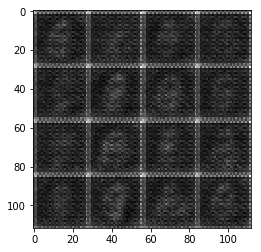

Epoch 1/2... Discriminator Loss: 1.3574... Generator Loss: 0.7250
Epoch 1/2... Discriminator Loss: 1.3342... Generator Loss: 0.7602
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.6216
Epoch 1/2... Discriminator Loss: 1.3643... Generator Loss: 0.6229
Epoch 1/2... Discriminator Loss: 1.3953... Generator Loss: 0.5955
Epoch 1/2... Discriminator Loss: 1.3906... Generator Loss: 0.6037
Epoch 1/2... Discriminator Loss: 1.3710... Generator Loss: 0.5941
Epoch 1/2... Discriminator Loss: 1.3661... Generator Loss: 0.6018
Epoch 1/2... Discriminator Loss: 1.3924... Generator Loss: 0.5775
Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.5942


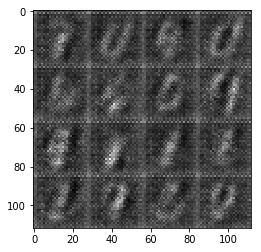

Epoch 1/2... Discriminator Loss: 1.3789... Generator Loss: 0.5775
Epoch 1/2... Discriminator Loss: 1.3770... Generator Loss: 0.5805
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.5710
Epoch 1/2... Discriminator Loss: 1.3832... Generator Loss: 0.5756
Epoch 1/2... Discriminator Loss: 1.3841... Generator Loss: 0.5828
Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.5771
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.5874
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.5907
Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 0.6110
Epoch 1/2... Discriminator Loss: 1.3813... Generator Loss: 0.5744


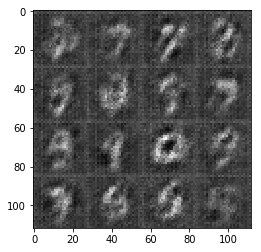

Epoch 1/2... Discriminator Loss: 1.3618... Generator Loss: 0.6074
Epoch 1/2... Discriminator Loss: 1.3665... Generator Loss: 0.5851
Epoch 1/2... Discriminator Loss: 1.3779... Generator Loss: 0.5847
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.6005
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 0.5767
Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 0.5958
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.5971
Epoch 1/2... Discriminator Loss: 1.3667... Generator Loss: 0.6124
Epoch 1/2... Discriminator Loss: 1.3770... Generator Loss: 0.5916
Epoch 1/2... Discriminator Loss: 1.3688... Generator Loss: 0.5940


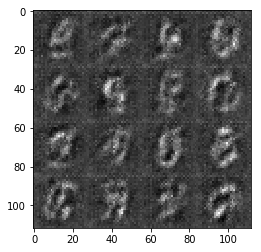

Epoch 1/2... Discriminator Loss: 1.3794... Generator Loss: 0.5876
Epoch 1/2... Discriminator Loss: 1.3876... Generator Loss: 0.5805
Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 0.6082
Epoch 1/2... Discriminator Loss: 1.3806... Generator Loss: 0.5827
Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.5779
Epoch 1/2... Discriminator Loss: 1.3680... Generator Loss: 0.6113
Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 0.5809
Epoch 1/2... Discriminator Loss: 1.3752... Generator Loss: 0.5959
Epoch 1/2... Discriminator Loss: 1.3708... Generator Loss: 0.5927
Epoch 1/2... Discriminator Loss: 1.3651... Generator Loss: 0.6173


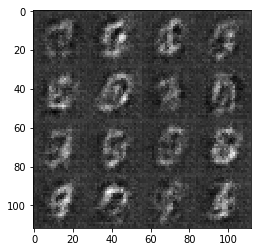

Epoch 1/2... Discriminator Loss: 1.3699... Generator Loss: 0.5976
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.5807
Epoch 1/2... Discriminator Loss: 1.3777... Generator Loss: 0.5923
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.5697
Epoch 1/2... Discriminator Loss: 1.3831... Generator Loss: 0.5822
Epoch 1/2... Discriminator Loss: 1.3692... Generator Loss: 0.5963
Epoch 1/2... Discriminator Loss: 1.3730... Generator Loss: 0.5896
Epoch 1/2... Discriminator Loss: 1.3660... Generator Loss: 0.6102
Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 0.6339
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 0.6145


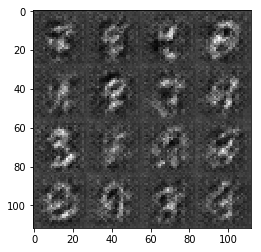

Epoch 1/2... Discriminator Loss: 1.3822... Generator Loss: 0.5689
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 0.6118
Epoch 1/2... Discriminator Loss: 1.3808... Generator Loss: 0.6197
Epoch 1/2... Discriminator Loss: 1.3813... Generator Loss: 0.6147
Epoch 1/2... Discriminator Loss: 1.3722... Generator Loss: 0.5944
Epoch 1/2... Discriminator Loss: 1.3720... Generator Loss: 0.6042
Epoch 1/2... Discriminator Loss: 1.3683... Generator Loss: 0.5875
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 0.5752
Epoch 1/2... Discriminator Loss: 1.3848... Generator Loss: 0.5957
Epoch 1/2... Discriminator Loss: 1.3612... Generator Loss: 0.6105


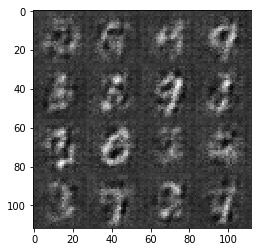

Epoch 1/2... Discriminator Loss: 1.3665... Generator Loss: 0.5816
Epoch 1/2... Discriminator Loss: 1.3601... Generator Loss: 0.5771
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 0.5707
Epoch 1/2... Discriminator Loss: 1.3563... Generator Loss: 0.5907
Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 0.5610
Epoch 1/2... Discriminator Loss: 1.3898... Generator Loss: 0.5912
Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 0.6032
Epoch 1/2... Discriminator Loss: 1.3432... Generator Loss: 0.6032
Epoch 1/2... Discriminator Loss: 1.3907... Generator Loss: 0.5695
Epoch 1/2... Discriminator Loss: 1.3883... Generator Loss: 0.5486


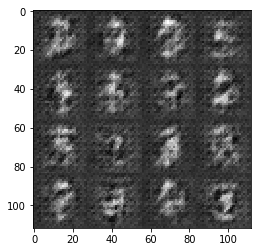

Epoch 1/2... Discriminator Loss: 1.3147... Generator Loss: 0.6004
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.6364
Epoch 1/2... Discriminator Loss: 1.4002... Generator Loss: 0.5648
Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 0.5761
Epoch 1/2... Discriminator Loss: 1.3166... Generator Loss: 0.6392
Epoch 1/2... Discriminator Loss: 1.3606... Generator Loss: 0.5933
Epoch 1/2... Discriminator Loss: 1.2247... Generator Loss: 0.7329
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.5639
Epoch 1/2... Discriminator Loss: 1.2889... Generator Loss: 0.6408
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.5748


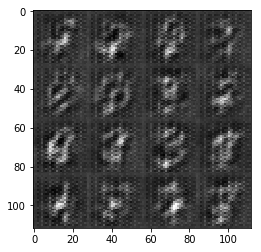

Epoch 1/2... Discriminator Loss: 1.3410... Generator Loss: 0.5865
Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 0.6008
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.5978
Epoch 1/2... Discriminator Loss: 1.3240... Generator Loss: 0.5682
Epoch 1/2... Discriminator Loss: 1.2976... Generator Loss: 0.5830
Epoch 1/2... Discriminator Loss: 1.3411... Generator Loss: 0.5897
Epoch 1/2... Discriminator Loss: 1.3043... Generator Loss: 0.5980
Epoch 1/2... Discriminator Loss: 1.3832... Generator Loss: 0.5765
Epoch 1/2... Discriminator Loss: 1.3644... Generator Loss: 0.5636
Epoch 1/2... Discriminator Loss: 1.3414... Generator Loss: 0.5903


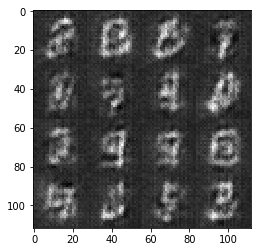

Epoch 1/2... Discriminator Loss: 1.2859... Generator Loss: 0.6033
Epoch 1/2... Discriminator Loss: 1.3093... Generator Loss: 0.5721
Epoch 1/2... Discriminator Loss: 1.3598... Generator Loss: 0.5808
Epoch 1/2... Discriminator Loss: 1.2830... Generator Loss: 0.6348
Epoch 1/2... Discriminator Loss: 1.2976... Generator Loss: 0.5871
Epoch 1/2... Discriminator Loss: 1.3087... Generator Loss: 0.5990
Epoch 1/2... Discriminator Loss: 1.3114... Generator Loss: 0.5914
Epoch 1/2... Discriminator Loss: 1.2834... Generator Loss: 0.5907
Epoch 1/2... Discriminator Loss: 1.2561... Generator Loss: 0.6564
Epoch 1/2... Discriminator Loss: 1.2971... Generator Loss: 0.6465


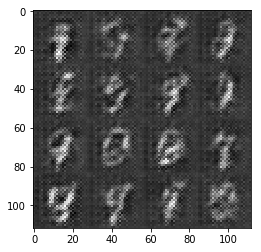

Epoch 1/2... Discriminator Loss: 1.2719... Generator Loss: 0.6630
Epoch 1/2... Discriminator Loss: 1.3285... Generator Loss: 0.5565
Epoch 1/2... Discriminator Loss: 1.2589... Generator Loss: 0.6860
Epoch 1/2... Discriminator Loss: 1.3249... Generator Loss: 0.6502
Epoch 1/2... Discriminator Loss: 1.2617... Generator Loss: 0.6604
Epoch 1/2... Discriminator Loss: 1.2894... Generator Loss: 0.6578
Epoch 1/2... Discriminator Loss: 1.2563... Generator Loss: 0.7011
Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 0.5934
Epoch 1/2... Discriminator Loss: 1.3362... Generator Loss: 0.6257
Epoch 1/2... Discriminator Loss: 1.2881... Generator Loss: 0.6169


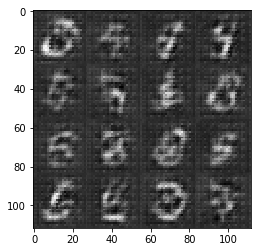

Epoch 1/2... Discriminator Loss: 1.2735... Generator Loss: 0.5679
Epoch 1/2... Discriminator Loss: 1.2841... Generator Loss: 0.6890
Epoch 1/2... Discriminator Loss: 1.2639... Generator Loss: 0.6101
Epoch 1/2... Discriminator Loss: 1.3085... Generator Loss: 0.5765
Epoch 1/2... Discriminator Loss: 1.1560... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 1.2032... Generator Loss: 0.6321
Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 0.6495
Epoch 1/2... Discriminator Loss: 1.2511... Generator Loss: 0.6515
Epoch 1/2... Discriminator Loss: 1.1547... Generator Loss: 0.8411
Epoch 1/2... Discriminator Loss: 1.1941... Generator Loss: 0.7959


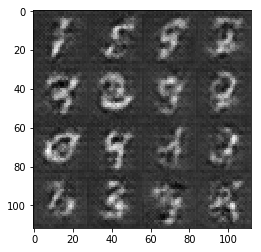

Epoch 1/2... Discriminator Loss: 1.3032... Generator Loss: 0.7509
Epoch 1/2... Discriminator Loss: 1.2228... Generator Loss: 0.8404
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 0.6504
Epoch 1/2... Discriminator Loss: 1.2653... Generator Loss: 0.7889
Epoch 1/2... Discriminator Loss: 1.2499... Generator Loss: 0.5510
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 0.7702
Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 0.8296
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 0.7593
Epoch 1/2... Discriminator Loss: 1.2690... Generator Loss: 0.6248
Epoch 1/2... Discriminator Loss: 1.1978... Generator Loss: 0.8520


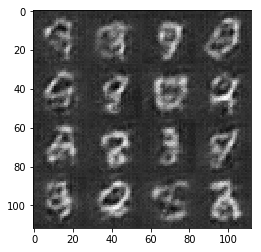

Epoch 1/2... Discriminator Loss: 1.2734... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 1.1936... Generator Loss: 0.8007
Epoch 1/2... Discriminator Loss: 1.2588... Generator Loss: 0.7751
Epoch 1/2... Discriminator Loss: 1.2863... Generator Loss: 0.5579
Epoch 1/2... Discriminator Loss: 1.1742... Generator Loss: 0.7543
Epoch 1/2... Discriminator Loss: 1.1684... Generator Loss: 0.7155
Epoch 1/2... Discriminator Loss: 1.2262... Generator Loss: 0.5542
Epoch 1/2... Discriminator Loss: 1.1586... Generator Loss: 0.6471
Epoch 1/2... Discriminator Loss: 1.1567... Generator Loss: 0.8443
Epoch 1/2... Discriminator Loss: 1.2275... Generator Loss: 0.6485


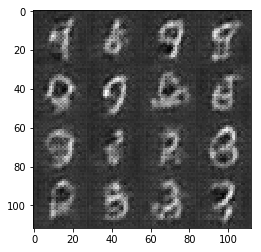

Epoch 1/2... Discriminator Loss: 1.2787... Generator Loss: 0.7131
Epoch 1/2... Discriminator Loss: 1.1274... Generator Loss: 0.8917
Epoch 1/2... Discriminator Loss: 1.2688... Generator Loss: 0.7059
Epoch 1/2... Discriminator Loss: 1.2246... Generator Loss: 0.5446
Epoch 1/2... Discriminator Loss: 1.3250... Generator Loss: 0.7885
Epoch 1/2... Discriminator Loss: 1.2641... Generator Loss: 1.1319
Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 0.5241
Epoch 1/2... Discriminator Loss: 1.2172... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.2341... Generator Loss: 0.8039
Epoch 1/2... Discriminator Loss: 1.1911... Generator Loss: 0.7365


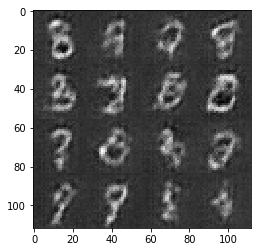

Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 0.4993
Epoch 1/2... Discriminator Loss: 1.1975... Generator Loss: 0.6858
Epoch 1/2... Discriminator Loss: 1.2096... Generator Loss: 0.6349
Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 0.8279
Epoch 1/2... Discriminator Loss: 1.2309... Generator Loss: 0.6704
Epoch 1/2... Discriminator Loss: 1.2578... Generator Loss: 0.4709
Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 0.8467
Epoch 1/2... Discriminator Loss: 1.2903... Generator Loss: 0.7762
Epoch 1/2... Discriminator Loss: 1.2762... Generator Loss: 0.9024
Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 0.7956


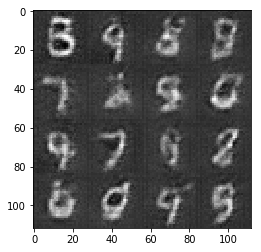

Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 0.6418
Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 0.4281
Epoch 1/2... Discriminator Loss: 1.2235... Generator Loss: 0.5859
Epoch 1/2... Discriminator Loss: 1.2636... Generator Loss: 0.5144
Epoch 1/2... Discriminator Loss: 1.2433... Generator Loss: 0.6128
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 0.7623
Epoch 1/2... Discriminator Loss: 1.1355... Generator Loss: 0.8463
Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 0.4923
Epoch 1/2... Discriminator Loss: 1.1675... Generator Loss: 0.6312
Epoch 1/2... Discriminator Loss: 1.1807... Generator Loss: 0.7165


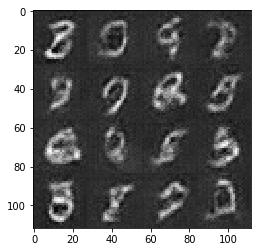

Epoch 1/2... Discriminator Loss: 1.1509... Generator Loss: 0.7763
Epoch 1/2... Discriminator Loss: 1.2666... Generator Loss: 0.6370
Epoch 1/2... Discriminator Loss: 1.1816... Generator Loss: 0.7650
Epoch 1/2... Discriminator Loss: 1.1991... Generator Loss: 0.5694
Epoch 1/2... Discriminator Loss: 1.1729... Generator Loss: 0.9324
Epoch 1/2... Discriminator Loss: 1.3264... Generator Loss: 0.5067
Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 0.7153
Epoch 2/2... Discriminator Loss: 1.1555... Generator Loss: 0.7959
Epoch 2/2... Discriminator Loss: 1.1686... Generator Loss: 0.5640
Epoch 2/2... Discriminator Loss: 1.1849... Generator Loss: 0.7322


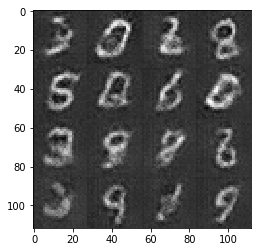

Epoch 2/2... Discriminator Loss: 1.2143... Generator Loss: 0.7280
Epoch 2/2... Discriminator Loss: 1.2171... Generator Loss: 0.5577
Epoch 2/2... Discriminator Loss: 1.2388... Generator Loss: 0.6751
Epoch 2/2... Discriminator Loss: 1.2752... Generator Loss: 0.5837
Epoch 2/2... Discriminator Loss: 1.1330... Generator Loss: 0.7184
Epoch 2/2... Discriminator Loss: 1.2071... Generator Loss: 0.6101
Epoch 2/2... Discriminator Loss: 1.2332... Generator Loss: 0.7929
Epoch 2/2... Discriminator Loss: 1.2934... Generator Loss: 0.4973
Epoch 2/2... Discriminator Loss: 1.2396... Generator Loss: 0.6880
Epoch 2/2... Discriminator Loss: 1.3328... Generator Loss: 0.8464


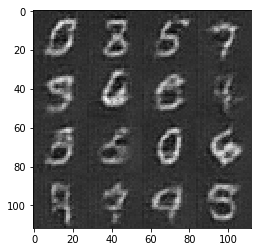

Epoch 2/2... Discriminator Loss: 1.2366... Generator Loss: 0.6994
Epoch 2/2... Discriminator Loss: 1.1977... Generator Loss: 0.6570
Epoch 2/2... Discriminator Loss: 1.3406... Generator Loss: 0.4110
Epoch 2/2... Discriminator Loss: 1.1606... Generator Loss: 0.9279
Epoch 2/2... Discriminator Loss: 1.2398... Generator Loss: 0.7302
Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 0.5442
Epoch 2/2... Discriminator Loss: 1.2249... Generator Loss: 0.6111
Epoch 2/2... Discriminator Loss: 1.2177... Generator Loss: 0.6483
Epoch 2/2... Discriminator Loss: 1.1699... Generator Loss: 0.7834
Epoch 2/2... Discriminator Loss: 1.1453... Generator Loss: 0.8746


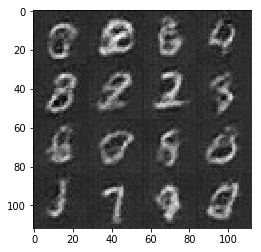

Epoch 2/2... Discriminator Loss: 1.1800... Generator Loss: 0.5987
Epoch 2/2... Discriminator Loss: 1.1463... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 1.2467... Generator Loss: 0.6972
Epoch 2/2... Discriminator Loss: 1.1359... Generator Loss: 0.7452
Epoch 2/2... Discriminator Loss: 1.1774... Generator Loss: 0.7174
Epoch 2/2... Discriminator Loss: 1.1659... Generator Loss: 0.7901
Epoch 2/2... Discriminator Loss: 1.2133... Generator Loss: 0.7714
Epoch 2/2... Discriminator Loss: 1.2406... Generator Loss: 0.5923
Epoch 2/2... Discriminator Loss: 1.1757... Generator Loss: 0.6370
Epoch 2/2... Discriminator Loss: 1.1592... Generator Loss: 0.6404


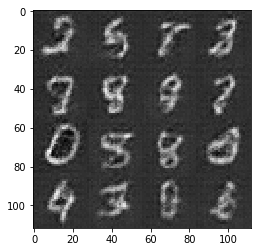

Epoch 2/2... Discriminator Loss: 1.3445... Generator Loss: 0.4182
Epoch 2/2... Discriminator Loss: 1.2594... Generator Loss: 0.5610
Epoch 2/2... Discriminator Loss: 1.1504... Generator Loss: 0.6748
Epoch 2/2... Discriminator Loss: 1.2271... Generator Loss: 0.6525
Epoch 2/2... Discriminator Loss: 1.1802... Generator Loss: 0.6389
Epoch 2/2... Discriminator Loss: 1.2043... Generator Loss: 1.0877
Epoch 2/2... Discriminator Loss: 1.2323... Generator Loss: 0.6403
Epoch 2/2... Discriminator Loss: 1.1182... Generator Loss: 0.6565
Epoch 2/2... Discriminator Loss: 1.2034... Generator Loss: 0.6292
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 0.7216


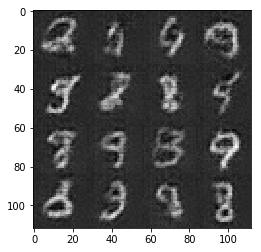

Epoch 2/2... Discriminator Loss: 1.2031... Generator Loss: 0.6795
Epoch 2/2... Discriminator Loss: 1.1361... Generator Loss: 0.7597
Epoch 2/2... Discriminator Loss: 1.2369... Generator Loss: 0.6434
Epoch 2/2... Discriminator Loss: 1.1459... Generator Loss: 0.7592
Epoch 2/2... Discriminator Loss: 1.1687... Generator Loss: 0.8642
Epoch 2/2... Discriminator Loss: 1.2874... Generator Loss: 0.8161
Epoch 2/2... Discriminator Loss: 1.1630... Generator Loss: 0.6989
Epoch 2/2... Discriminator Loss: 1.2921... Generator Loss: 0.5646
Epoch 2/2... Discriminator Loss: 1.2627... Generator Loss: 0.5227
Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 0.6772


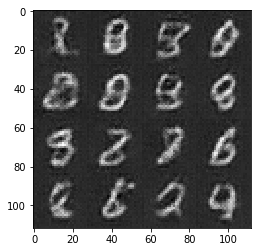

Epoch 2/2... Discriminator Loss: 1.3115... Generator Loss: 0.8879
Epoch 2/2... Discriminator Loss: 1.1087... Generator Loss: 0.7298
Epoch 2/2... Discriminator Loss: 1.2089... Generator Loss: 0.5759
Epoch 2/2... Discriminator Loss: 1.2165... Generator Loss: 0.7432
Epoch 2/2... Discriminator Loss: 1.1875... Generator Loss: 0.7224
Epoch 2/2... Discriminator Loss: 1.1798... Generator Loss: 0.9123
Epoch 2/2... Discriminator Loss: 1.2418... Generator Loss: 0.6939
Epoch 2/2... Discriminator Loss: 1.1649... Generator Loss: 0.7767
Epoch 2/2... Discriminator Loss: 1.1820... Generator Loss: 0.6956
Epoch 2/2... Discriminator Loss: 1.2244... Generator Loss: 0.6554


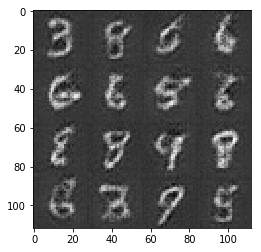

Epoch 2/2... Discriminator Loss: 1.2837... Generator Loss: 0.5348
Epoch 2/2... Discriminator Loss: 1.0900... Generator Loss: 0.8380
Epoch 2/2... Discriminator Loss: 1.2267... Generator Loss: 0.6110
Epoch 2/2... Discriminator Loss: 1.1595... Generator Loss: 0.6123
Epoch 2/2... Discriminator Loss: 1.1286... Generator Loss: 0.8715
Epoch 2/2... Discriminator Loss: 1.3691... Generator Loss: 0.4664
Epoch 2/2... Discriminator Loss: 1.1405... Generator Loss: 1.0414
Epoch 2/2... Discriminator Loss: 1.1835... Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 1.2343... Generator Loss: 0.7136
Epoch 2/2... Discriminator Loss: 1.1969... Generator Loss: 0.7815


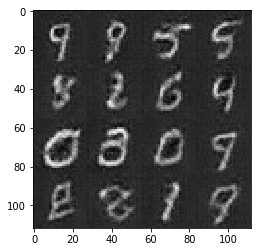

Epoch 2/2... Discriminator Loss: 1.1975... Generator Loss: 0.7013
Epoch 2/2... Discriminator Loss: 1.1641... Generator Loss: 0.7567
Epoch 2/2... Discriminator Loss: 1.2626... Generator Loss: 0.6509
Epoch 2/2... Discriminator Loss: 1.1730... Generator Loss: 0.7671
Epoch 2/2... Discriminator Loss: 1.2886... Generator Loss: 0.6345
Epoch 2/2... Discriminator Loss: 1.2038... Generator Loss: 0.6480
Epoch 2/2... Discriminator Loss: 1.3239... Generator Loss: 0.7313
Epoch 2/2... Discriminator Loss: 1.1882... Generator Loss: 0.6165
Epoch 2/2... Discriminator Loss: 1.1597... Generator Loss: 0.7471
Epoch 2/2... Discriminator Loss: 1.1995... Generator Loss: 0.7268


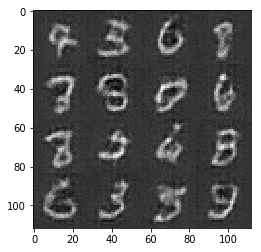

Epoch 2/2... Discriminator Loss: 1.2289... Generator Loss: 0.7161
Epoch 2/2... Discriminator Loss: 1.1084... Generator Loss: 0.6062
Epoch 2/2... Discriminator Loss: 1.1931... Generator Loss: 0.5954
Epoch 2/2... Discriminator Loss: 1.1604... Generator Loss: 0.8936
Epoch 2/2... Discriminator Loss: 1.2103... Generator Loss: 0.5925
Epoch 2/2... Discriminator Loss: 1.2133... Generator Loss: 0.6819
Epoch 2/2... Discriminator Loss: 1.2690... Generator Loss: 0.7047
Epoch 2/2... Discriminator Loss: 1.2731... Generator Loss: 0.6655
Epoch 2/2... Discriminator Loss: 1.0874... Generator Loss: 0.6421
Epoch 2/2... Discriminator Loss: 1.3019... Generator Loss: 0.5803


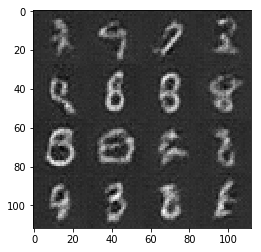

Epoch 2/2... Discriminator Loss: 1.2693... Generator Loss: 0.7592
Epoch 2/2... Discriminator Loss: 1.4458... Generator Loss: 0.3956
Epoch 2/2... Discriminator Loss: 1.2860... Generator Loss: 0.5162
Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 0.7221
Epoch 2/2... Discriminator Loss: 1.1610... Generator Loss: 0.8313
Epoch 2/2... Discriminator Loss: 1.2929... Generator Loss: 0.5021
Epoch 2/2... Discriminator Loss: 1.2910... Generator Loss: 0.6610
Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 1.1960... Generator Loss: 0.6417
Epoch 2/2... Discriminator Loss: 1.2153... Generator Loss: 0.6505


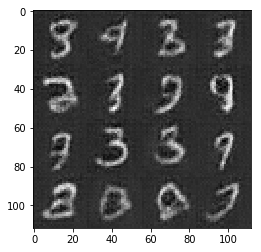

Epoch 2/2... Discriminator Loss: 1.1609... Generator Loss: 0.8273
Epoch 2/2... Discriminator Loss: 1.1590... Generator Loss: 0.9862
Epoch 2/2... Discriminator Loss: 1.2411... Generator Loss: 0.6066
Epoch 2/2... Discriminator Loss: 1.1394... Generator Loss: 0.6665
Epoch 2/2... Discriminator Loss: 1.2742... Generator Loss: 0.5972
Epoch 2/2... Discriminator Loss: 1.2276... Generator Loss: 0.9230
Epoch 2/2... Discriminator Loss: 1.3067... Generator Loss: 0.5171
Epoch 2/2... Discriminator Loss: 1.0728... Generator Loss: 0.8665
Epoch 2/2... Discriminator Loss: 1.2231... Generator Loss: 0.7860
Epoch 2/2... Discriminator Loss: 1.1864... Generator Loss: 0.6676


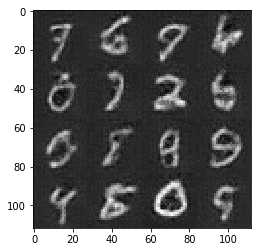

Epoch 2/2... Discriminator Loss: 1.2618... Generator Loss: 0.6161
Epoch 2/2... Discriminator Loss: 1.0682... Generator Loss: 0.8476
Epoch 2/2... Discriminator Loss: 1.1800... Generator Loss: 0.6672
Epoch 2/2... Discriminator Loss: 1.2375... Generator Loss: 0.6665
Epoch 2/2... Discriminator Loss: 1.2072... Generator Loss: 0.5368
Epoch 2/2... Discriminator Loss: 1.1894... Generator Loss: 0.6229
Epoch 2/2... Discriminator Loss: 1.2334... Generator Loss: 0.5206
Epoch 2/2... Discriminator Loss: 1.1549... Generator Loss: 0.6872
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 0.7643
Epoch 2/2... Discriminator Loss: 1.1766... Generator Loss: 0.6924


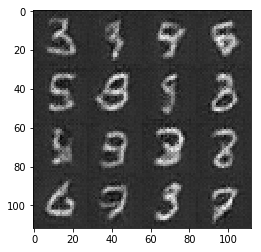

Epoch 2/2... Discriminator Loss: 1.1396... Generator Loss: 0.7897
Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 0.7594
Epoch 2/2... Discriminator Loss: 1.3277... Generator Loss: 0.4768
Epoch 2/2... Discriminator Loss: 1.1357... Generator Loss: 1.0066
Epoch 2/2... Discriminator Loss: 1.1448... Generator Loss: 0.8684
Epoch 2/2... Discriminator Loss: 1.1676... Generator Loss: 0.8013
Epoch 2/2... Discriminator Loss: 1.1845... Generator Loss: 0.6394
Epoch 2/2... Discriminator Loss: 1.0855... Generator Loss: 1.1086
Epoch 2/2... Discriminator Loss: 1.2484... Generator Loss: 0.5123
Epoch 2/2... Discriminator Loss: 1.1376... Generator Loss: 0.9158


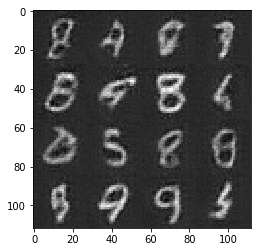

Epoch 2/2... Discriminator Loss: 1.1916... Generator Loss: 0.4753
Epoch 2/2... Discriminator Loss: 1.1606... Generator Loss: 0.7989
Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 0.4379
Epoch 2/2... Discriminator Loss: 1.3642... Generator Loss: 0.4589
Epoch 2/2... Discriminator Loss: 1.1908... Generator Loss: 0.6577
Epoch 2/2... Discriminator Loss: 1.1612... Generator Loss: 0.6386
Epoch 2/2... Discriminator Loss: 1.2147... Generator Loss: 0.5506
Epoch 2/2... Discriminator Loss: 1.2902... Generator Loss: 0.9252
Epoch 2/2... Discriminator Loss: 1.2244... Generator Loss: 0.6209
Epoch 2/2... Discriminator Loss: 1.2407... Generator Loss: 0.6533


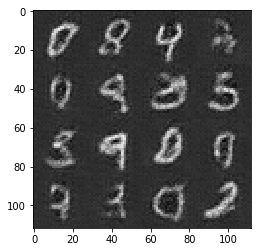

Epoch 2/2... Discriminator Loss: 1.2651... Generator Loss: 0.5872
Epoch 2/2... Discriminator Loss: 1.3108... Generator Loss: 0.4365
Epoch 2/2... Discriminator Loss: 1.2582... Generator Loss: 0.6132
Epoch 2/2... Discriminator Loss: 1.2320... Generator Loss: 0.7669
Epoch 2/2... Discriminator Loss: 1.4227... Generator Loss: 0.4524
Epoch 2/2... Discriminator Loss: 1.1758... Generator Loss: 0.6601
Epoch 2/2... Discriminator Loss: 1.1476... Generator Loss: 0.8286
Epoch 2/2... Discriminator Loss: 1.1698... Generator Loss: 0.8392
Epoch 2/2... Discriminator Loss: 1.0839... Generator Loss: 0.8674
Epoch 2/2... Discriminator Loss: 1.1007... Generator Loss: 0.7115


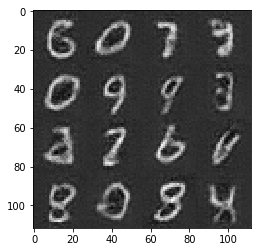

Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 0.5638
Epoch 2/2... Discriminator Loss: 1.1127... Generator Loss: 0.8909
Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 0.7729
Epoch 2/2... Discriminator Loss: 1.1746... Generator Loss: 0.6979
Epoch 2/2... Discriminator Loss: 1.2666... Generator Loss: 0.7381
Epoch 2/2... Discriminator Loss: 1.1815... Generator Loss: 0.7037
Epoch 2/2... Discriminator Loss: 1.2354... Generator Loss: 0.7539
Epoch 2/2... Discriminator Loss: 1.1362... Generator Loss: 0.6375
Epoch 2/2... Discriminator Loss: 1.1631... Generator Loss: 0.9275
Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 0.8775


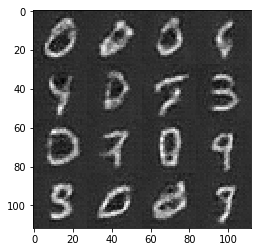

Epoch 2/2... Discriminator Loss: 1.1227... Generator Loss: 0.7982
Epoch 2/2... Discriminator Loss: 1.2031... Generator Loss: 0.8215
Epoch 2/2... Discriminator Loss: 1.1754... Generator Loss: 0.8606
Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 0.8963
Epoch 2/2... Discriminator Loss: 1.1941... Generator Loss: 0.5956
Epoch 2/2... Discriminator Loss: 1.2013... Generator Loss: 0.5382
Epoch 2/2... Discriminator Loss: 1.1326... Generator Loss: 0.5866
Epoch 2/2... Discriminator Loss: 1.2254... Generator Loss: 0.6491
Epoch 2/2... Discriminator Loss: 1.2633... Generator Loss: 0.9573
Epoch 2/2... Discriminator Loss: 1.1774... Generator Loss: 0.5869


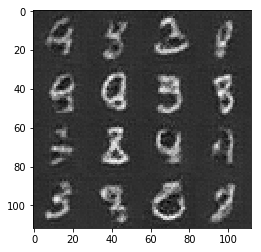

Epoch 2/2... Discriminator Loss: 1.2053... Generator Loss: 0.6506
Epoch 2/2... Discriminator Loss: 1.2197... Generator Loss: 0.8940
Epoch 2/2... Discriminator Loss: 1.1428... Generator Loss: 0.6404
Epoch 2/2... Discriminator Loss: 1.1761... Generator Loss: 0.7350
Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 0.8385
Epoch 2/2... Discriminator Loss: 1.1682... Generator Loss: 0.7923
Epoch 2/2... Discriminator Loss: 1.1134... Generator Loss: 0.5961
Epoch 2/2... Discriminator Loss: 1.2367... Generator Loss: 0.6045
Epoch 2/2... Discriminator Loss: 1.2680... Generator Loss: 0.5695
Epoch 2/2... Discriminator Loss: 1.1490... Generator Loss: 0.5987


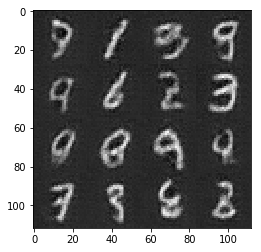

Epoch 2/2... Discriminator Loss: 1.2013... Generator Loss: 0.7606
Epoch 2/2... Discriminator Loss: 1.1758... Generator Loss: 0.6046
Epoch 2/2... Discriminator Loss: 1.1874... Generator Loss: 0.8686
Epoch 2/2... Discriminator Loss: 1.1092... Generator Loss: 0.9067
Epoch 2/2... Discriminator Loss: 1.1368... Generator Loss: 0.7280


In [306]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.7065


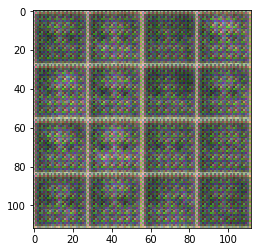

Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.5124


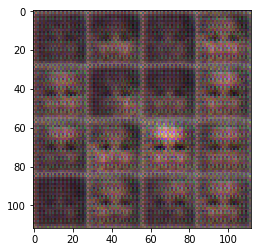

Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.4916
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.5355
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.6064


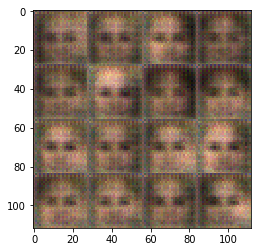

Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.6074


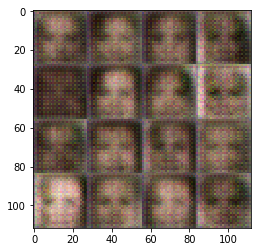

Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6031


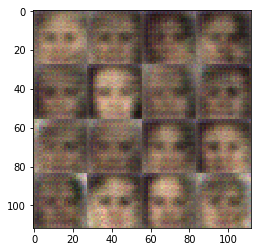

Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6126


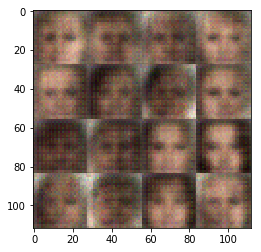

Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.5826
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.5739


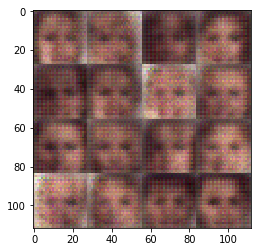

Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 0.9096... Generator Loss: 1.2263
Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 1.1504
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 1.1718
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.7008


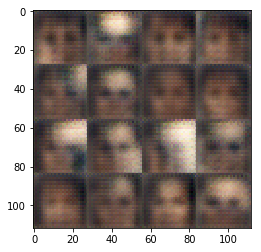

Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.5156
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.4223
Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 1.4097


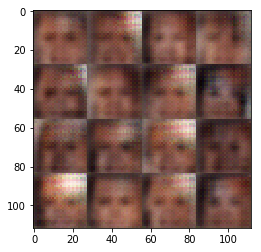

Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 0.9145... Generator Loss: 2.1944
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 2.3098
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.5024
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 0.9862... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.6593


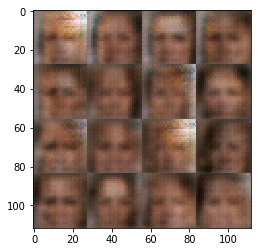

Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.7021
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 1.1521
Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 2.5413
Epoch 1/1... Discriminator Loss: 1.7001... Generator Loss: 0.4159
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 1.4544
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.4286
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 0.8518... Generator Loss: 1.4004
Epoch 1/1... Discriminator Loss: 0.9137... Generator Loss: 1.8395


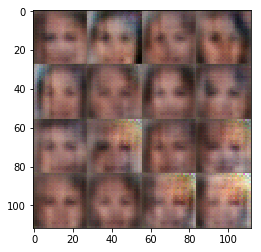

Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 2.1452
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.4723
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 1.3919
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 1.1916
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.2467


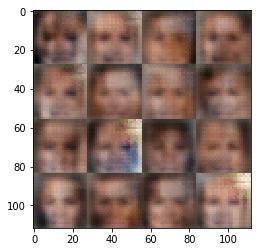

Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 1.5931
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 1.3246
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.4839
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 1.0711


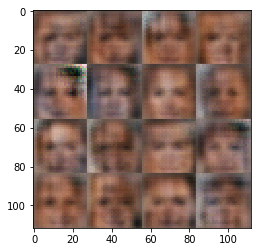

Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 1.3570
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 4.6301
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.3047
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 2.2114
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 0.9359


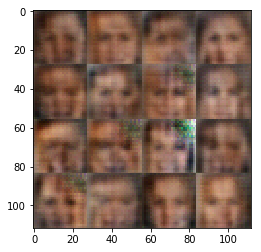

Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.1825
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 3.4543
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 1.0850


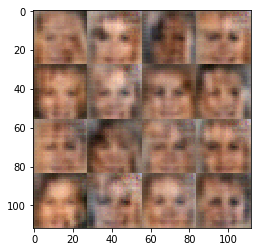

Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 1.4775
Epoch 1/1... Discriminator Loss: 0.8846... Generator Loss: 3.4566
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 2.2468
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.3225
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 2.2885
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 0.8851


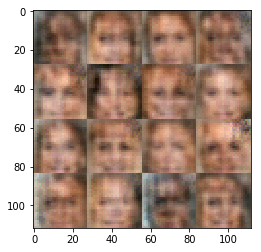

Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.3955
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 0.8849... Generator Loss: 1.5381
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 1.0695
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 2.6275
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.6256


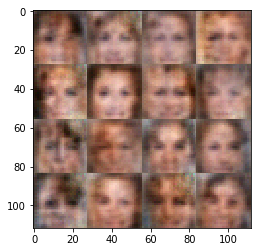

Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.4962
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 1.3183
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 0.8727... Generator Loss: 1.3506
Epoch 1/1... Discriminator Loss: 1.5590... Generator Loss: 0.3626
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 1.0264
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.6503


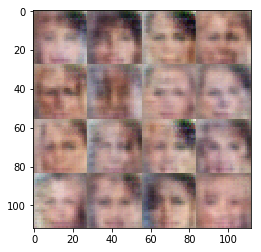

Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 0.9663
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 1.6332
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 1.0243
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 1.2365
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 1.0003
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.5486


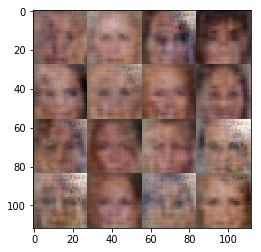

Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 1.8102
Epoch 1/1... Discriminator Loss: 0.8103... Generator Loss: 2.0515
Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 1.3618
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.5140


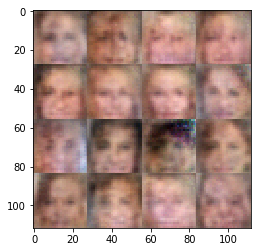

Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.5154
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 0.9250... Generator Loss: 1.1476
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 1.2623


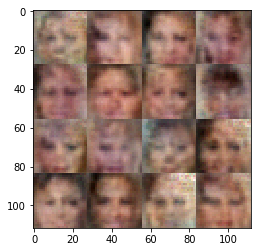

Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 1.1579
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 1.2024
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.8904


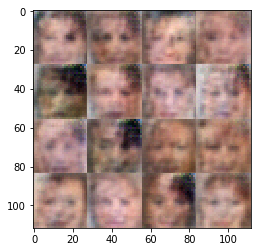

Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 1.3656
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.5489
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.9990


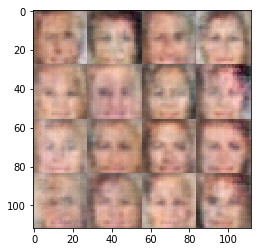

Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 1.4258
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.3741
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 1.2646
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.9905
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 1.2122
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 0.8670... Generator Loss: 1.3609


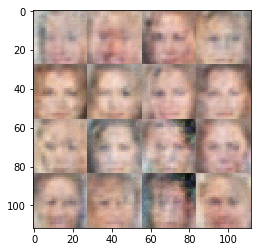

Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 1.1653
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 1.3335
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.7362


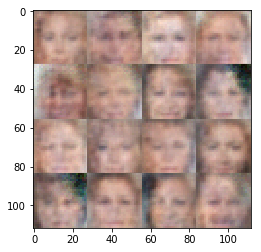

Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 2.4897
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 1.8499
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.7594


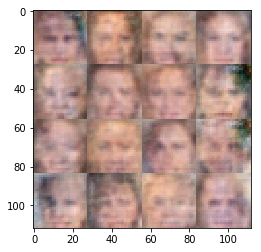

Epoch 1/1... Discriminator Loss: 1.5961... Generator Loss: 1.9307
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.7338


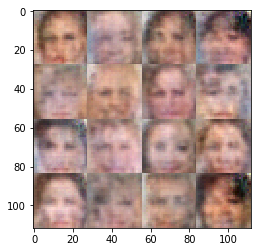

Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 1.7970
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.1638


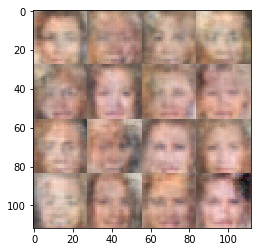

Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 1.4647
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 1.9714
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 1.2233
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 1.2221
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 1.8097
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 1.1021


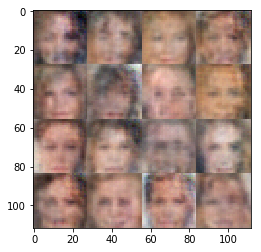

Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 1.3595
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.9422
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 1.1621
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 1.0887


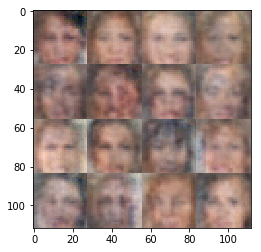

Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 1.4977
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 1.2408
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.7149


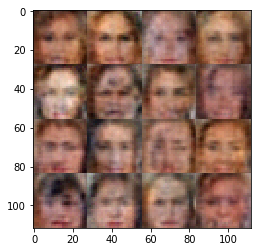

Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 2.1036
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 0.8349... Generator Loss: 2.0242
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 2.2059
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.8063


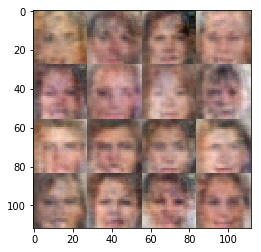

Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 1.5983
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 1.2748
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.6314
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 1.2073


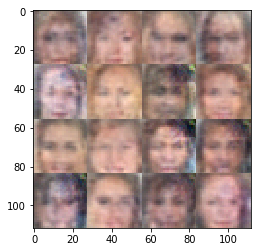

Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.4495
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 1.3327


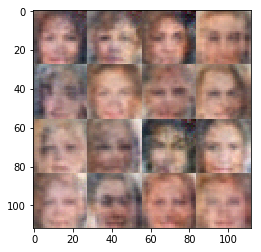

Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.1906
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 1.3853
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.7035
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 1.4126
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 1.0621


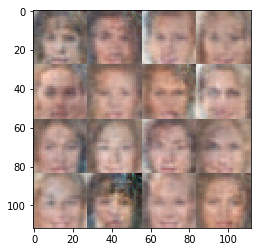

Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.1053
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.6375
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.1622
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.3264
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 1.1291
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 1.2741


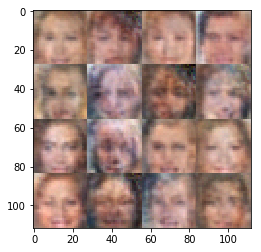

Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 1.3651
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 1.4243
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 2.2835
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 2.3243


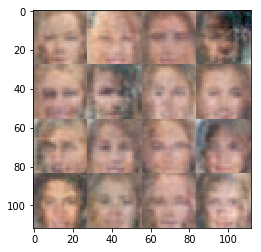

Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 1.2732
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 1.2181
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 2.4399
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.4322
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.2882
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 1.2088
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 1.1905
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.8289


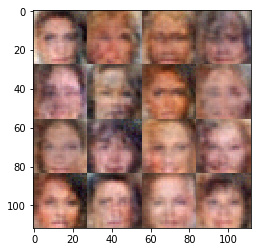

Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 1.0470


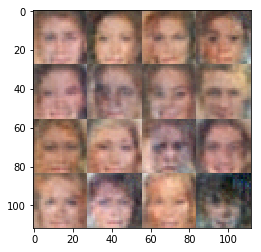

Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 1.2241
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 1.1579
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 1.2968


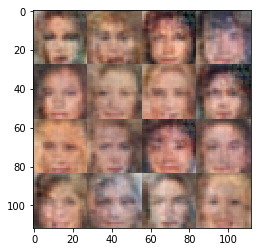

Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 1.1926
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 1.6471
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.6277


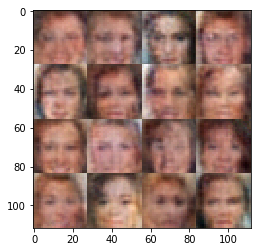

Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 1.1322
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 1.3156
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 1.5655
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.9212
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.0526


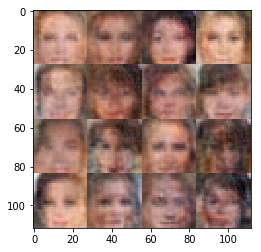

Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 1.1362
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 1.5204
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.5146


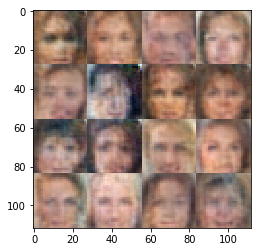

Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 1.3069
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 1.2123
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 1.0503
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 1.1099
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 1.2651
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 1.0239


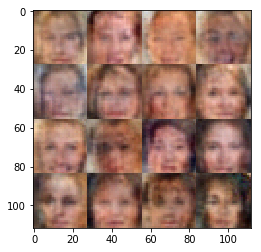

Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 1.0447
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 3.8596
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 2.2685
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 1.3078
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.8993


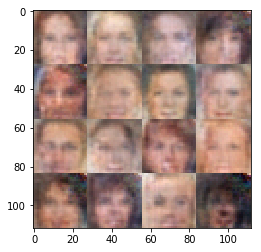

Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 1.3302
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 1.1147
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 1.1873
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 1.3741
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.1688
Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 1.4783


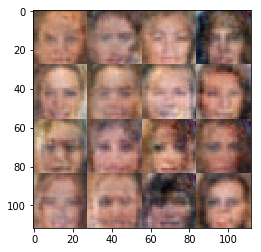

Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.4953
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.2417
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 1.3627
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 1.0359


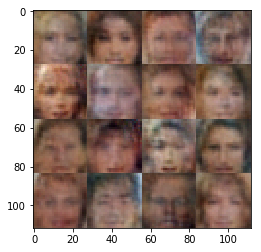

Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 1.3520
Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 1.8585
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.3207
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 0.8969


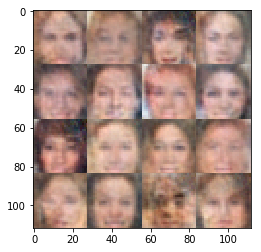

Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.7217
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 1.0148
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 1.2499
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 2.4753
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 1.9103


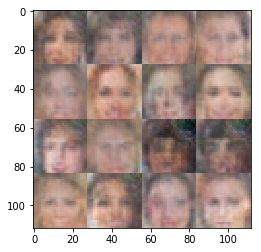

Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 1.1440
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 1.2281
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 1.2114
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.3799
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 2.0203


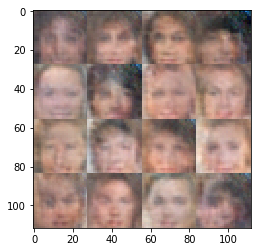

Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 1.1949
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 1.2413
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.9663
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 1.0527
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.8101


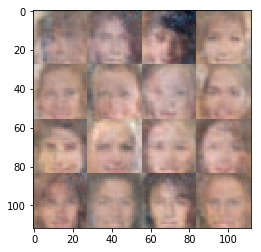

Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 1.4874
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 1.0713
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 1.5643
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 2.2962
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.4742
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 0.9859
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.5846


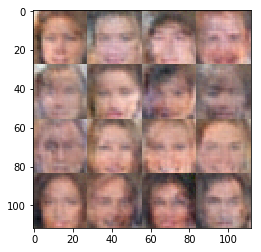

Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 1.3040
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 1.3183
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.1945


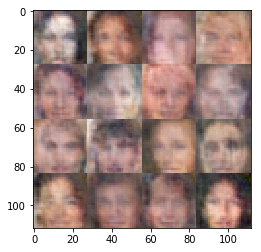

Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 1.3475
Epoch 1/1... Discriminator Loss: 0.8048... Generator Loss: 3.3121
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.6403
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 1.3698
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 1.2205
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 0.8529


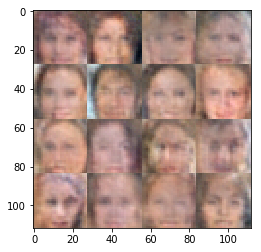

Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 1.2027
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 1.2011
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.5997
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.5357
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.1344


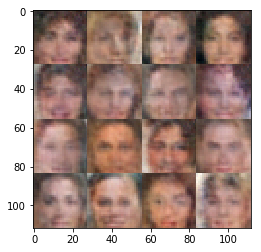

Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 1.3442
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 1.1047
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.4977
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 1.0308
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.5900
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.7722


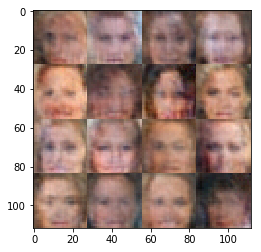

Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 1.0914
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.3459
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.4883
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 1.3801
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 0.8016


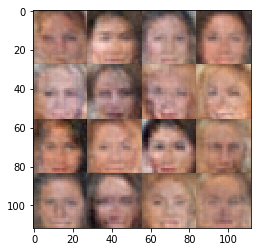

Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 2.0235
Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 1.2414
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 2.0555
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.2918
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 2.7456
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.4276


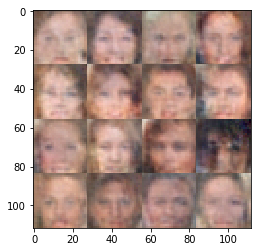

Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 1.0849
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 1.0373
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 1.3654
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.4900
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 0.9609


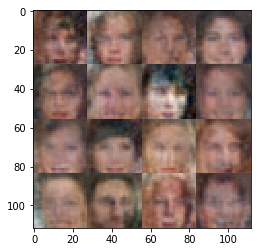

Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.3407
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 0.9010


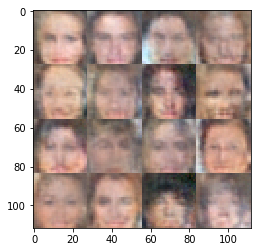

Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 1.0443
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 1.0350
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.2503
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.9737
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.6762


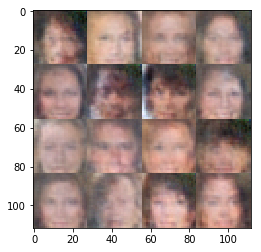

Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 1.0913
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 1.1534
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 1.4223
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 1.1614
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.6225


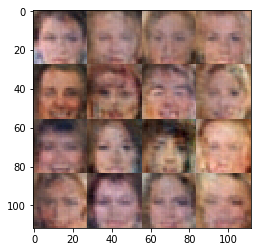

Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.1489
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 1.1800
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 0.9023... Generator Loss: 1.6903
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.2667


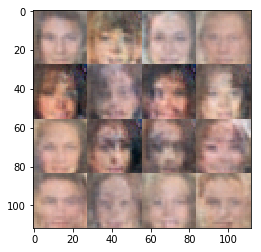

Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.0949
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 1.2070


In [305]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.